In [20]:
import pathlib
import os
import sys
from torch.utils.data import DataLoader

PACKAGE_PARENT = pathlib.Path.cwd().parent 
SCR_DIR = os.path.join(PACKAGE_PARENT, 'src')
sys.path.append(SCR_DIR)

from config.loc_config import TRAIN_DATA_LOC, TEST_DATA_LOC, PRED_DATA_LOC, ANNOT_LOC, MODEL_SAVE_LOC, REPORT_SAVE_LOC
from config.data_config import INPUT_WIDTH, INPUT_HEIGHT, INPUT_CHANNEL, BATCH_SIZE, NUM_WORKERS
from preprocessing.utils import build_annotation_csv, check_annot_dataframe, transform_bilinear
from model.dataset import IntelDataset, create_validation_dataset
import model.cnn_model as cnn_model
from postprocessing.utils import save_model_with_timestamp, save_csv_with_timestamp

In [22]:
import importlib
import model.dataset
import model.cnn_model as cnn_model
import config.loc_config
import postprocessing.utils
importlib.reload(model.dataset)
importlib.reload(model.cnn_model)
importlib.reload(config.loc_config)
importlib.reload(postprocessing.utils)
from model.dataset import IntelDataset, create_validation_dataset
import model.cnn_model as cnn_model
import config.loc_config
from postprocessing.utils import save_model_with_timestamp, save_csv_with_timestamp

### 1. Creating and Preprocessing Input Dataset

In [25]:
train_df = build_annotation_csv(image_location=TRAIN_DATA_LOC, annot_location=ANNOT_LOC, output_csv_name='train.csv')
test_df = build_annotation_csv(image_location=TEST_DATA_LOC, annot_location=ANNOT_LOC, output_csv_name='test.csv')
class_names = list(train_df['class_name'].unique())
print(class_names)
print(check_annot_dataframe(train_df))
print(check_annot_dataframe(test_df))

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
[(0, 'buildings'), (3, 'mountain'), (1, 'forest'), (5, 'street'), (2, 'glacier'), (4, 'sea')]
[(0, 'buildings'), (3, 'mountain'), (1, 'forest'), (5, 'street'), (2, 'glacier'), (4, 'sea')]


In [26]:
image_transform = transform_bilinear(INPUT_WIDTH, INPUT_HEIGHT)
main_dataset = IntelDataset(annot_df = train_df, transform=image_transform)
train_dataset, validation_dataset = create_validation_dataset(main_dataset, validation_proportion=0.2)
print('Train set size: ', len(train_dataset))
print('Validation set size: ', len(validation_dataset))

test_dataset = IntelDataset(annot_df = test_df, transform=image_transform)
print('Test set size: ', len(test_dataset))

11227 2807
Train set size:  11227
Validation set size:  2807
Test set size:  3000


c:\Users\phuon\OneDrive\Documents\GitHub\intel_img_clf_pytorch\venv39\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


### 2. Configuring the Dataloaders

In [27]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

### 3. Training and Exporting CNN Model

#### 3.1. With 10 Epochs

Current device: cpu
Is Model on CUDA: False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
            Conv2d-2         [-1, 16, 224, 224]           2,320
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
            Conv2d-5         [-1, 32, 112, 112]           9,248
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
            Conv2d-8           [-1, 64, 56, 56]          36,928
            Conv2d-9           [-1, 64, 56, 56]          36,928
        MaxPool2d-10           [-1, 64, 28, 28]               0
           Linear-11                  [-1, 500]      25,088,500
           Linear-12                   [-1, 50]          25,050
           Linear-13                    [-1, 6]            

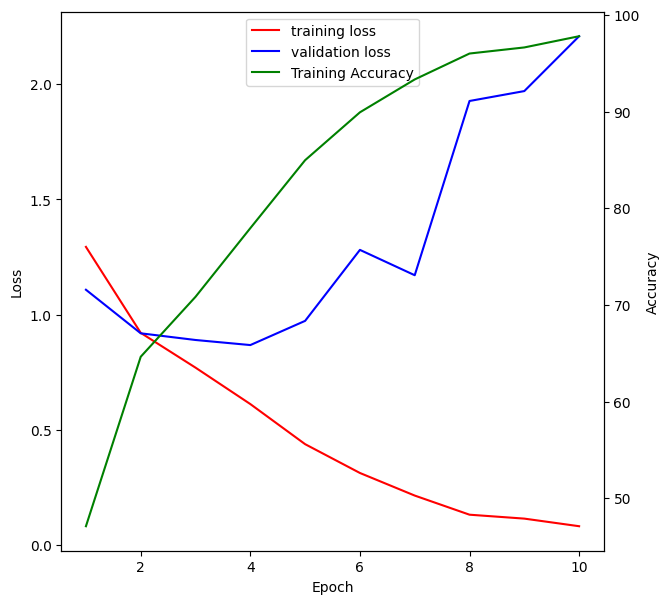

In [6]:
# initiation
model = cnn_model.MyCnnModel()
device = cnn_model.get_default_device()
cnn_model.model_prep_and_summary(model, device)
criterion = cnn_model.default_loss()
optimizer = cnn_model.default_optimizer(model = model)
num_epochs = 10

# get training results
trained_model, train_result_dict = cnn_model.train_model(model, device, train_loader, val_loader, criterion, optimizer, num_epochs)
cnn_model.visualize_training(train_result_dict)

In [15]:
save_model_with_timestamp(trained_model, MODEL_SAVE_LOC)

Saved model to:  ..\data\04_model\20230107_125216_cnn_model.pt


In [23]:
save_csv_with_timestamp(train_result_dict, REPORT_SAVE_LOC)

Saved training report to:  ..\data\06_reporting\20230107_141104_training_report.csv


#### 3.2. With 5 Epochs

Current device: cpu
Is Model on CUDA: False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
            Conv2d-2         [-1, 16, 224, 224]           2,320
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
            Conv2d-5         [-1, 32, 112, 112]           9,248
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
            Conv2d-8           [-1, 64, 56, 56]          36,928
            Conv2d-9           [-1, 64, 56, 56]          36,928
        MaxPool2d-10           [-1, 64, 28, 28]               0
           Linear-11                  [-1, 500]      25,088,500
           Linear-12                   [-1, 50]          25,050
           Linear-13                    [-1, 6]            

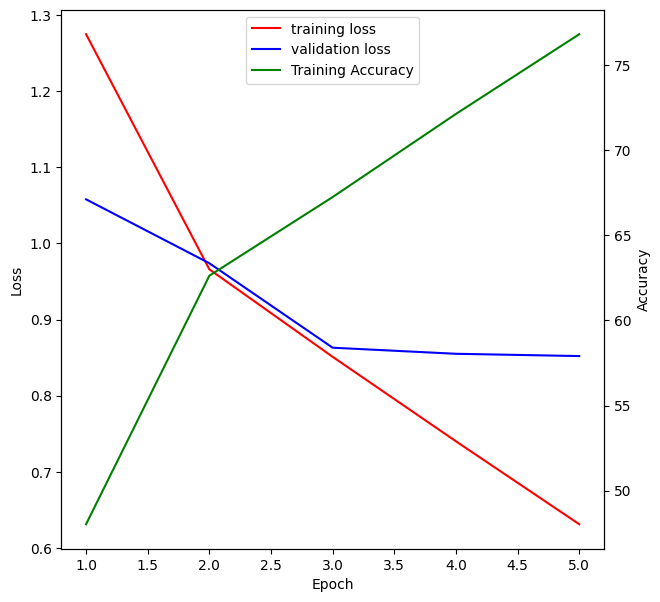

In [28]:
# initiation
model = cnn_model.MyCnnModel()
device = cnn_model.get_default_device()
cnn_model.model_prep_and_summary(model, device)
criterion = cnn_model.default_loss()
optimizer = cnn_model.default_optimizer(model = model)
num_epochs = 5

# get training results
trained_model, train_result_dict = cnn_model.train_model(model, device, train_loader, val_loader, criterion, optimizer, num_epochs)
cnn_model.visualize_training(train_result_dict)

In [29]:
save_model_with_timestamp(trained_model, MODEL_SAVE_LOC)

Saved model to:  ..\data\04_model\20230107_155535_cnn_model.pt


In [30]:
save_csv_with_timestamp(train_result_dict, REPORT_SAVE_LOC)

Saved training report to:  ..\data\06_reporting\20230107_155536_training_report.csv
